# Домашнее задание №1. Softmax Regression.

Нужно реализовать много-классовую логистическую регрессию с помощью softmax c поддержкой L1/L2 регуляризации. После этого сравнить с sklearn реализацией [SGDClassifier(loss="log_loss")](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier)
.

## Задание №1 (10 баллов)

Реализовать класс SoftMaxRegression и его методы - init, fit, predict c возможностью конфигурации
регуляризации.
Для оптимизации функции ошибки воспользоваться методом **стохастического градиентного спуска**.

Остальные функции реализовать на ваше усмотрение.

In [44]:
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [45]:
from os import pread

class SoftMaxRegression:
    def __init__(self, regularization_type=None, alpha=1e-4, max_iter=500, n_samples=1, learning_rate=1e-6):
        self.regularization_type = regularization_type
        self.max_iter = max_iter
        self.n_samples = n_samples
        self.learning_rate = learning_rate
        self.theta = 0
        self.alpha = alpha

    def onehot(self, y):
        y_oh = np.eye(self.classes)[np.array(y).reshape(-1)].reshape(list(y.shape)+[self.classes])
        return y_oh

    def softmax(self, x):
        '''
        x - object (1, n_features)
        theta - weights (n_features, n_classes)
        '''
        numerator = np.exp(-np.dot(self.theta.T,x))
        denominator = np.sum(numerator)
        return numerator / denominator

    def loss_function(self, X, y, theta):
        N = X.shape[0]
        yoh = self.onehot(y)
        #loss = 1/N * np.dot(X[0,:],(np.dot(theta,yoh[0,:].T)))
        #for i in range(1, N):
        #    sum = 0
        #    for c in range(yoh.shape[1]):
        #        sum += np.exp(-np.dot(X[i, :], np.dot(theta, yoh[c, :])))
        #    loss += 1/N * np.dot(X[i, :], np.dot(theta, yoh[i, :])) + np.log(sum)
        loss = -np.mean(np.log(self.predict_proba(X)[np.arange(X.shape[0]), np.array(y)]))
        if self.regularization_type == None:
            return loss
        elif self.regularization_type == 'l1':
            return loss + self.alpha * np.sum(np.abs(theta))

        else:
            return loss + self.alpha * np.sum(np.square(theta))

    def grad_lossfun(self, X, y, theta):
        yoh = self.onehot(y)
        N = X.shape[0]
        P = self.predict_proba(X)
        grad = 1/N * (X.T @ (yoh - P))
        if self.regularization_type == None:
            return grad

        elif self.regularization_type == 'l1':
            return grad + self.alpha * np.sign(theta)

        else:
            return grad + self.alpha * (2*theta)

    def fit(self, X, y, Xtest, ytest):
        """функция обучения модели"""
        k = 0
        self.classes = np.max(y) + 1
        self.theta = np.random.rand(X.shape[1], np.max(y)+1)
        self.losses = [self.loss_function(X, y, self.theta)]
        self.losses_test = [self.loss_function(Xtest, ytest, self.theta)]
        self.scores = [self.score(Xtest, ytest)]
        min_loss = self.losses[0]
        while k < self.max_iter:
            k += 1
            random_ind = np.random.choice(X.shape[0], self.n_samples, replace=False)
            X1 = X[random_ind]
            y1 = np.array(y)[random_ind]
            avg_grad = 1/self.n_samples * self.grad_lossfun(X1, y1, self.theta)
            self.theta = self.theta - self.learning_rate * avg_grad
            self.losses.append(self.loss_function(X, y, self.theta))
            self.losses_test.append(self.loss_function(Xtest, ytest, self.theta))
            self.scores.append(self.score(X, y))
            #if self.losses[-1] > min_loss - 1e-3:
            #  break
            #else:
            #  min_loss = min(self.losses[-1], min_loss)

    def predict(self, X):
        """функция предсказания"""
        pred = np.argmax(self.predict_proba(X), axis=1)
        return pred

    def score(self, X, y):
        N = X.shape[0]
        y1 = np.array(y)
        count = len(np.where(self.predict(X) == y1)[0])
        return count / N

    def predict_proba(self, X):
      probs = np.apply_along_axis(self.softmax, axis=1, arr=X)
      return probs

## Задание №2 (10 баллов)

Загрузите любой датасет много-классовой классификации, сделайте предобработку, разбейте на тренировочную и тестовую выборку  и оцените работу вашего алгоритма. Предпочтительно использовать метрику точности(accuracy) для оценки алгоритма.

В рамках оценки, воспользуйтесь sklearn реализацией много-классовой логистической регрессии. **Проверьте что ваши метрики совпадают(+/-1-2%) на моделях без регуляризации, с L1 и с L2 регуляризации.**

#### Работа с датасетом (1 балл)

Загрузите выбранный датасет много-классовой классификации, обработайте его, сделайте разбиение на тренировочную и тестовую выборку. Датасеты для классификации можно взять например [**отсюда**](https://archive.ics.uci.edu/ml/datasets.php?format=&task=cla&att=&area=&numAtt=&numIns=&type=&sort=nameUp&view=table).

##### Загрузка датасета из библиотеки sklearn

In [46]:
X, y = load_wine(return_X_y=True, as_frame=True)

##### Тип данных и их статистика

In [47]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
dtypes: fl

In [48]:
X.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


In [49]:
X.describe(include='all')

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000


##### Матрица корреляции

<Axes: >

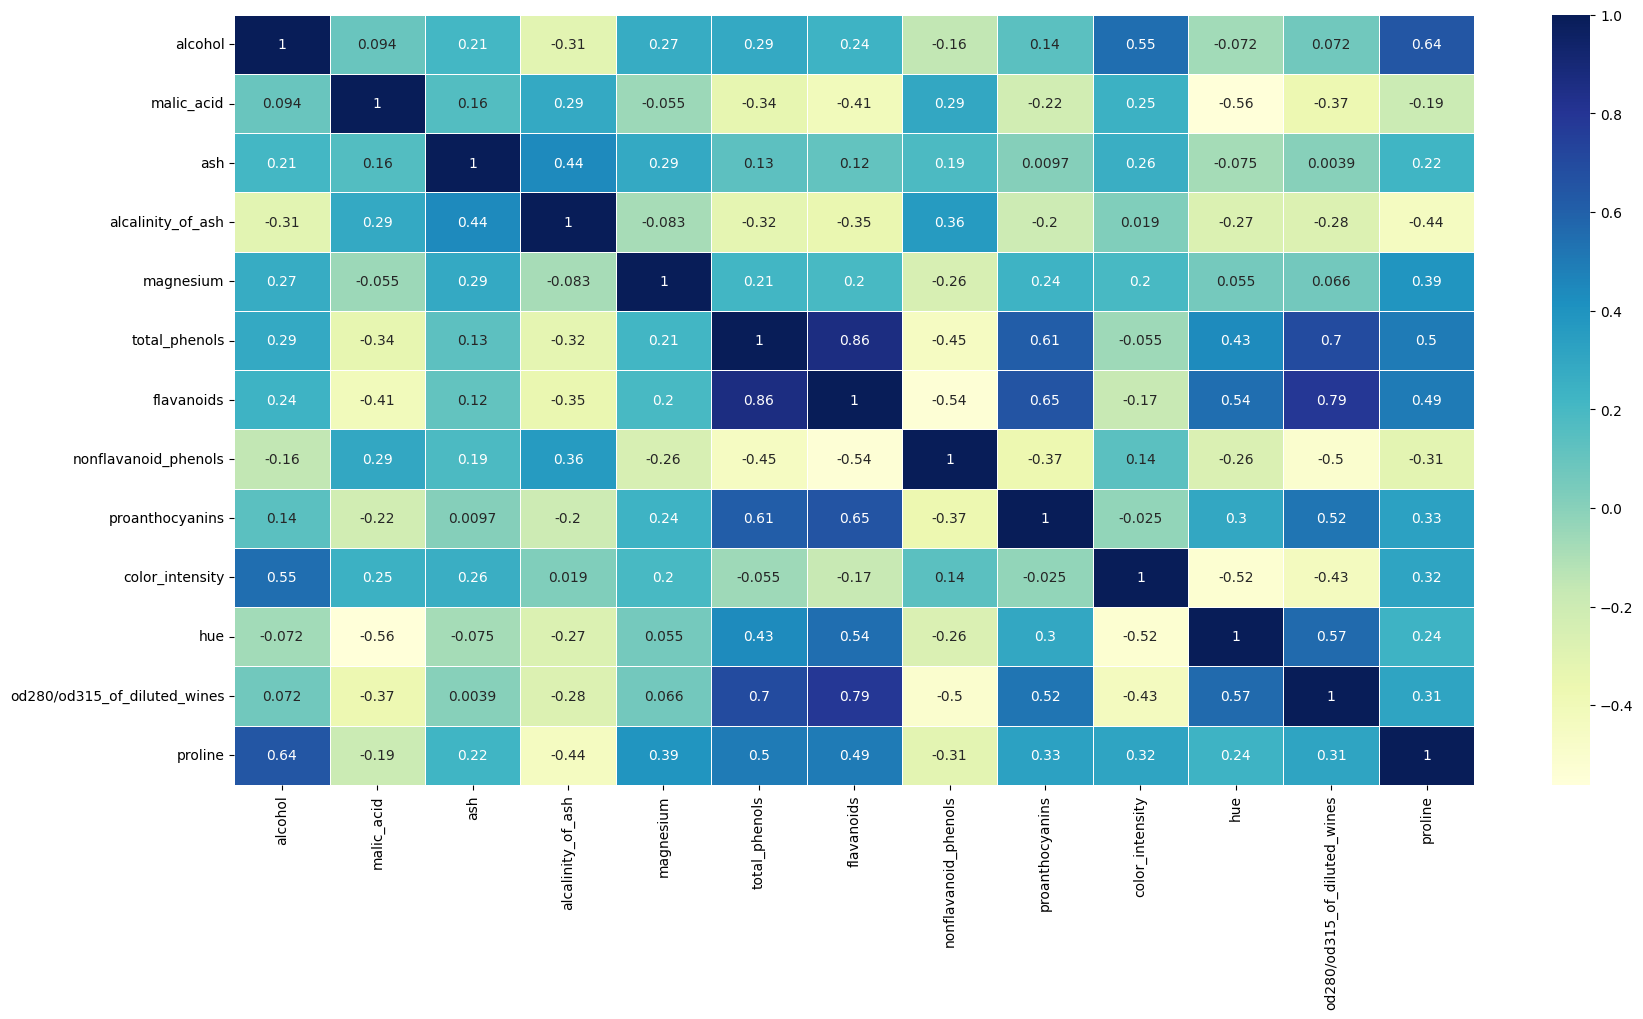

In [50]:
corrmat = X.corr()
fig, ax = plt.subplots()
fig.set_size_inches(20,10)
sns.heatmap(corrmat,cmap="YlGnBu",linewidths=.5,annot=True)

<ipython-input-51-a93b82cba96e>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(a=X['ash'],kde=False, bins=25)


<Axes: xlabel='ash'>

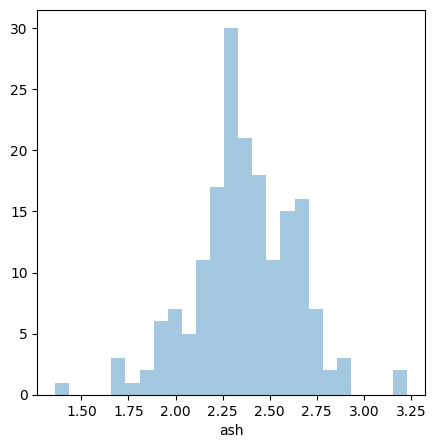

In [51]:
plt.figure(figsize=(5,5))
sns.distplot(a=X['ash'],kde=False, bins=25)

##### Разделим данные на train и test

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
X_train.shape, X_test.shape

((124, 13), (54, 13))

##### Проведем нормализацию данных на обучающей выборке

In [53]:
ss = StandardScaler().fit(X)

X_norm = ss.transform(X)
X_train_norm = ss.transform(X_train)
X_test_norm = ss.transform(X_test)

In [54]:
print(X_norm[:,2].mean())
print(X_norm[:,2].std())

-8.370333140713259e-16
1.0


#### Обучение модели и сравнение с sklearn имплементацией

Обучите 3 модели - обычную, с L1 реализацией, с L2 реализацией и сравните с аналогичной sklearn имплементацией много-классовой логистической регрессии.

В рамках обучения модели требуется визуализировать:

1) График падания значений ошибки на тренировочной выборке в зависимости от итерации.
2) График падания значений ошибки на валидационной выборке в зависимости от итерации.
3) График роста метрики точности в зависимости от итерации.

<span style="color:red">**Модель считается успешно реализованной, если целевая метрика совпадает с sklearn [реализацией](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier)   c log_loss функцией ошибки.
    
Если разница большая(более 2%), баллы за ДЗ не проставляются.**</span>

Ваши гиперпараметры должны совпадать с параметрами, которые вы указываете в sklearn версии.

#### Обучение обычной модели и сравнение с __SGDClassifier(loss="log_loss", penalty = 'none')__ (3 балла)

In [55]:
clf = SGDClassifier(loss='log_loss', penalty=None, verbose=0, learning_rate='constant', eta0=1e-1)
clf.fit(X_train_norm, y_train)

SGDClassifier(eta0=0.1, learning_rate='constant', loss='log_loss', penalty=None)

In [56]:
clf.score(X_test_norm,y_test)

1.0

In [57]:
smr = SoftMaxRegression(regularization_type=None, n_samples=20, learning_rate = 1e-1, max_iter=600)
smr.fit(X_train_norm, y_train, X_test_norm, y_test)

In [58]:
smr.score(X_test_norm, y_test)

0.9814814814814815

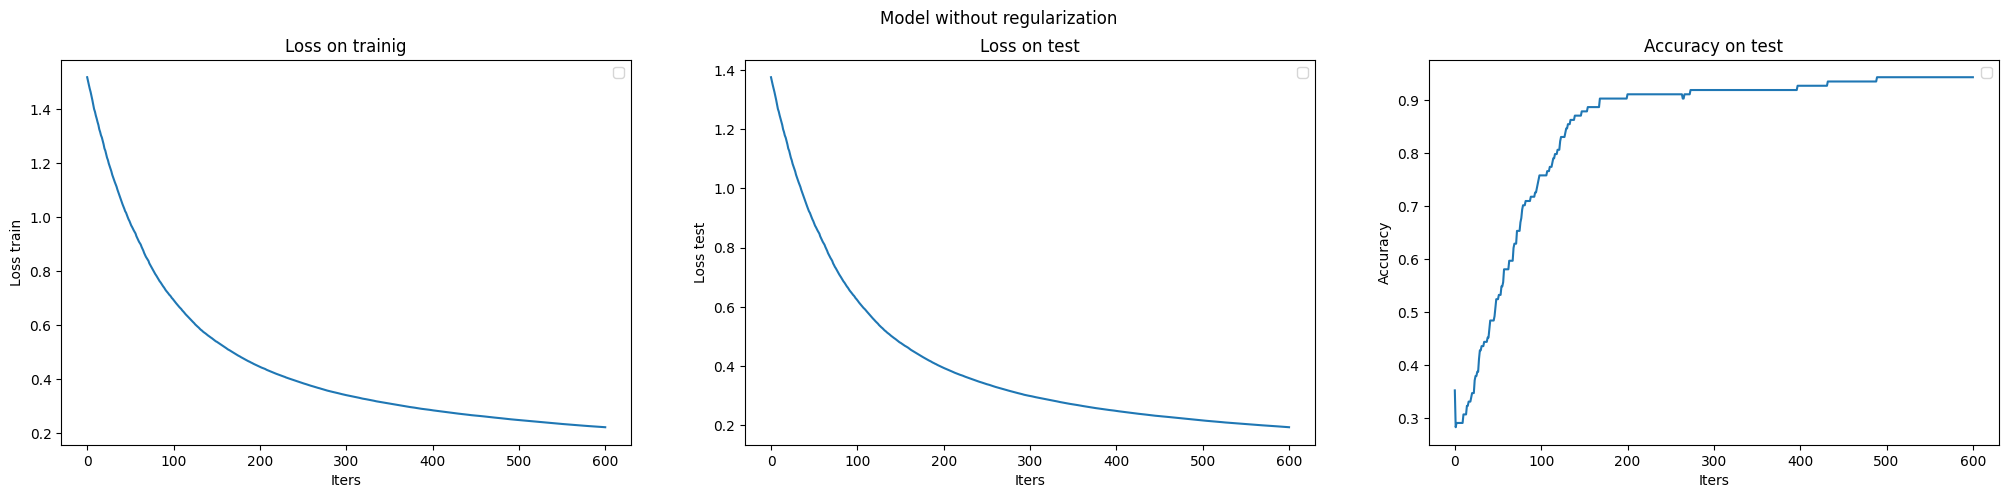

In [59]:
indices = list(range(len(smr.losses)))

fig,axes=plt.subplots(nrows=1,ncols=3,figsize=(25,5))
axes[0].plot(indices, smr.losses, linestyle='-')
axes[1].plot(indices, smr.losses_test, linestyle='-')
axes[2].plot(indices, smr.scores, linestyle='-')


axes[0].set_xlabel('Iters')
axes[0].set_ylabel('Loss train')

axes[1].set_xlabel('Iters')
axes[1].set_ylabel('Loss test')

axes[2].set_xlabel('Iters')
axes[2].set_ylabel('Accuracy')

axes[0].set_title('Loss on trainig')
axes[1].set_title('Loss on test')
axes[2].set_title('Accuracy on test')

axes[0].legend()
axes[1].legend()
axes[2].legend()

plt.suptitle('Model without regularization')

plt.show()

#### Обучение модели c L1 регуляризацией и сравнение с __SGDClassifier(loss="log_loss", penalty = 'l1')__ (3 балла)

In [60]:
clf_l1 = SGDClassifier(loss='log_loss', penalty='l1', verbose=0, learning_rate='constant', eta0=1e-1,
                      average=10)
clf_l1.fit(X_train_norm, y_train)

SGDClassifier(average=10, eta0=0.1, learning_rate='constant', loss='log_loss',
              penalty='l1')

In [61]:
clf_l1.score(X_test_norm,y_test)

1.0

In [62]:
smr_l1 = SoftMaxRegression(regularization_type='l1', n_samples=32, learning_rate = 1e-1, max_iter=1000)
smr_l1.fit(X_train_norm, y_train, X_test_norm, y_test)

In [63]:
smr_l1.score(X_test_norm, y_test)

0.8703703703703703

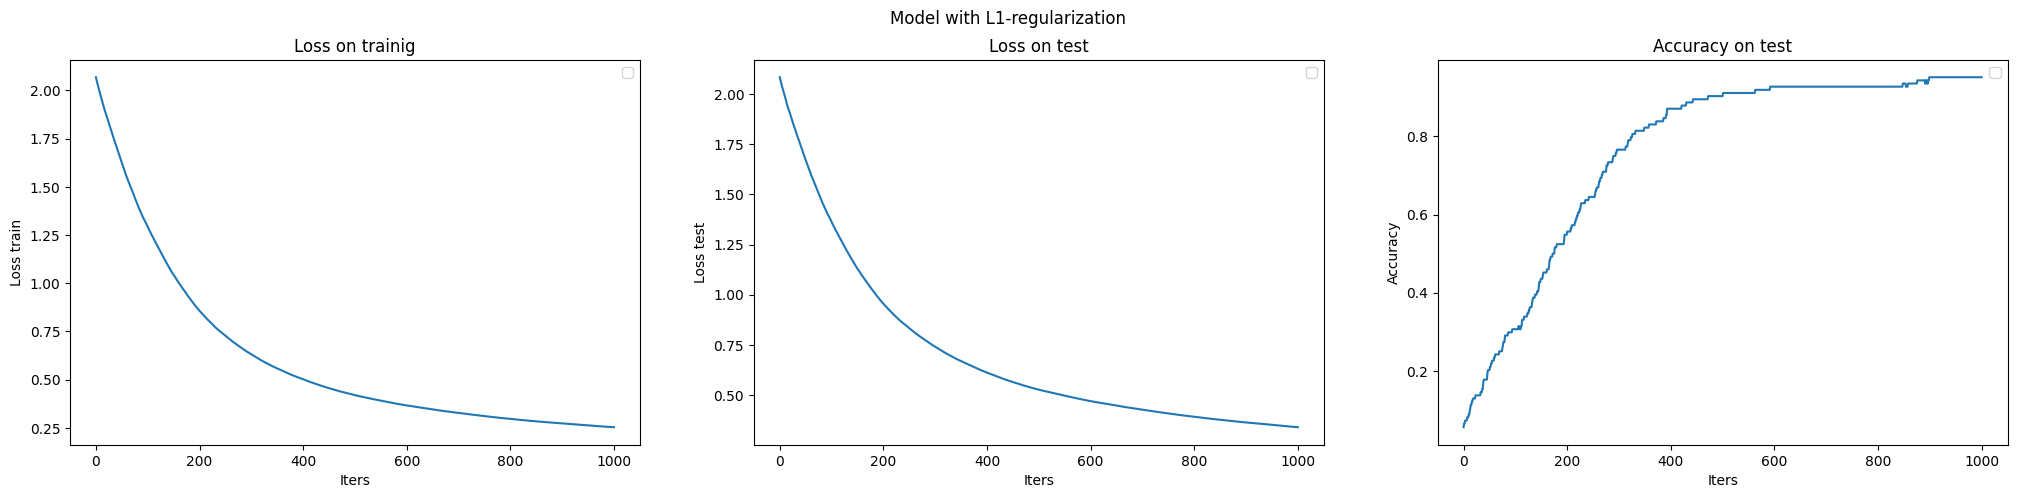

In [64]:
indices_l1 = list(range(len(smr_l1.losses)))

fig,axes=plt.subplots(nrows=1,ncols=3,figsize=(25,5))
axes[0].plot(indices_l1, smr_l1.losses, linestyle='-')
axes[1].plot(indices_l1, smr_l1.losses_test, linestyle='-')
axes[2].plot(indices_l1, smr_l1.scores, linestyle='-')


axes[0].set_xlabel('Iters')
axes[0].set_ylabel('Loss train')

axes[1].set_xlabel('Iters')
axes[1].set_ylabel('Loss test')

axes[2].set_xlabel('Iters')
axes[2].set_ylabel('Accuracy')

axes[0].set_title('Loss on trainig')
axes[1].set_title('Loss on test')
axes[2].set_title('Accuracy on test')

axes[0].legend()
axes[1].legend()
axes[2].legend()

plt.suptitle('Model with L1-regularization')

plt.show()

#### Обучение модели c L2 регуляризацией и сравнение с __SGDClassifier(loss="log_loss", penalty = 'l2')__ (3 балла)

In [65]:
clf_l2 = SGDClassifier(loss='log_loss', penalty='l2', alpha=1e-4, verbose=0, learning_rate='constant', eta0=1e-1,
                      average=10)
clf_l2.fit(X_train_norm, y_train)

SGDClassifier(average=10, eta0=0.1, learning_rate='constant', loss='log_loss')

In [66]:
clf_l2.score(X_test_norm,y_test)

1.0

In [67]:
smr_l2 = SoftMaxRegression(regularization_type='l2', n_samples=20, learning_rate = 1e-1, max_iter=1000)
smr_l2.fit(X_train_norm, y_train, X_test_norm, y_test)

In [68]:
smr_l2.score(X_test_norm, y_test)

0.9814814814814815

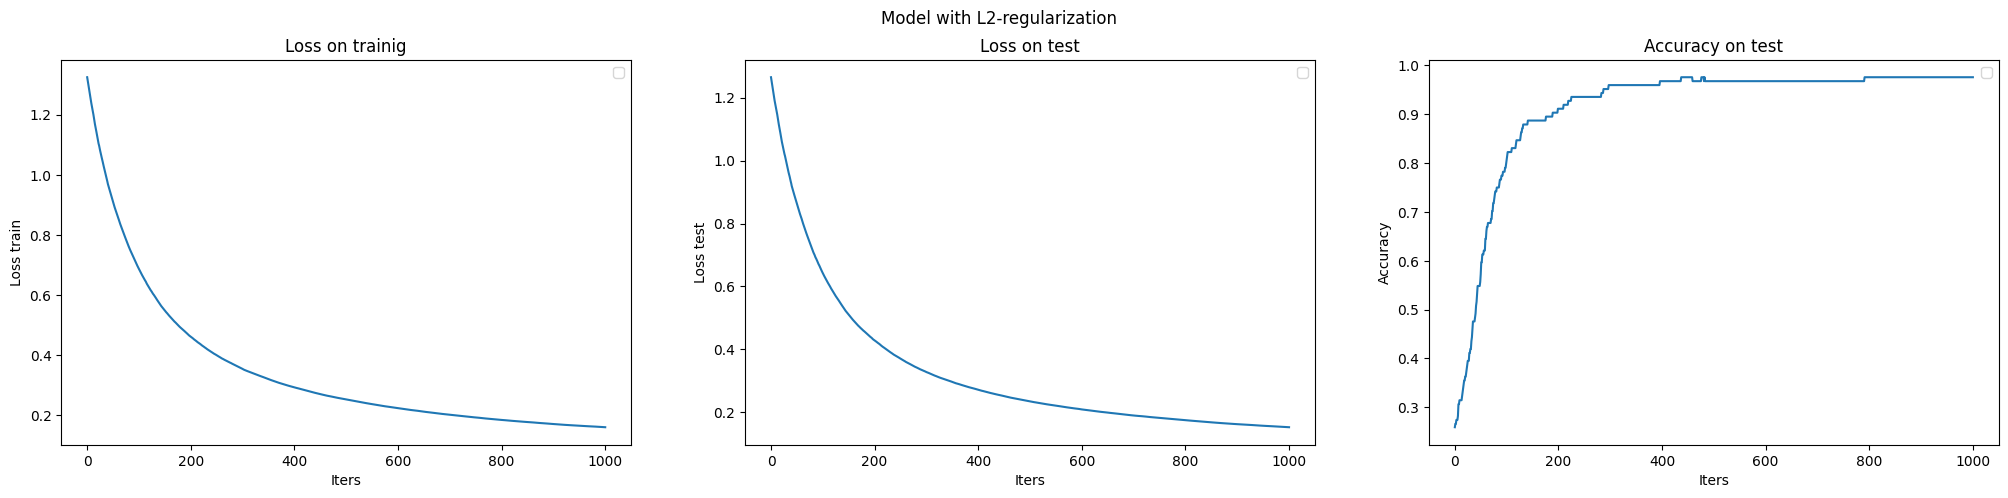

In [69]:
indices_l2 = list(range(len(smr_l2.losses)))

fig,axes=plt.subplots(nrows=1,ncols=3,figsize=(25,5))
axes[0].plot(indices_l2, smr_l2.losses, linestyle='-')
axes[1].plot(indices_l2, smr_l2.losses_test, linestyle='-')
axes[2].plot(indices_l2, smr_l2.scores, linestyle='-')


axes[0].set_xlabel('Iters')
axes[0].set_ylabel('Loss train')

axes[1].set_xlabel('Iters')
axes[1].set_ylabel('Loss test')

axes[2].set_xlabel('Iters')
axes[2].set_ylabel('Accuracy')

axes[0].set_title('Loss on trainig')
axes[1].set_title('Loss on test')
axes[2].set_title('Accuracy on test')

axes[0].legend()
axes[1].legend()
axes[2].legend()

plt.suptitle('Model with L2-regularization')

plt.show()